In [1]:
#import all necessary libraries
import mediapipe as mp
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import json
import pandas as pd
import shutil
import random

### One-Hot Ecoding on Classes

In [2]:
import tensorflow as tf
trainPath= "D:/lsa/keypoints/train"
glossLst=[]
#total unique gloss
for file in os.listdir(trainPath):
    glossLst.append(file)
    
glossLst= sorted(glossLst)
print(glossLst)

#perform one-hot encoding in glosses
idxarray=tf.keras.utils.to_categorical([i for i in range(len(glossLst))], num_classes=15)
class_ids=dict(zip(glossLst, idxarray))
class_ids

['Argentina', 'accept', 'appear', 'away', 'barbecue', 'bathe', 'birthday', 'bitter', 'born', 'breakfast', 'bright', 'buy', 'call', 'candy', 'catch']


{'Argentina': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'accept': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'appear': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'away': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'barbecue': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'bathe': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'birthday': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'bitter': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'born': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'breakfast': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]

### Prepare Training, Validation and Test Data

In [3]:
#training data
train_sequences, train_labels=[], []
folder="D:/lsa/keypoints/train"
for file in os.listdir(folder):
    filepath= folder+"/"+file
    for af in os.listdir(filepath):
        if af.endswith("npy"):
            apath= filepath+"/"+af
            res= np.load(apath)
            train_sequences.append(res)
            train_labels.append(class_ids[file])

In [4]:
x_train=np.array(train_sequences)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))

In [5]:
#validation data
val_sequences, val_labels=[], []
folder="D:/lsa/keypoints/val"
for file in os.listdir(folder):
    filepath= folder+"/"+file
    for af in os.listdir(filepath):
        if af.endswith("npy"):
            apath= filepath+"/"+af
            res= np.load(apath)
            val_sequences.append(res)
            val_labels.append(class_ids[file])

In [6]:
x_val=np.array(val_sequences)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, val_labels))

In [7]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [8]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 190, 267), dtype=tf.float64, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [9]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 190, 267), dtype=tf.float64, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [10]:
#test data
test_sequences, test_labels=[], []
folder="D:/lsa/keypoints/test"
for file in os.listdir(folder):
    filepath= folder+"/"+file
    for af in os.listdir(filepath):
        if af.endswith("npy"):
            apath= filepath+"/"+af
            res= np.load(apath)
            test_sequences.append(res)
            test_labels.append(class_ids[file])

In [11]:
x_test=np.array(test_sequences)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [12]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 190, 267), dtype=tf.float64, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

### Build Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM, Dense, Dropout, BatchNormalization, Flatten, Conv1D, MaxPooling1D, LeakyReLU, GRU
from keras_self_attention import SeqSelfAttention
import keras

In [14]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#### Conv-LSTM

In [15]:
model= Sequential()
model.add(Input(shape=(190, 267)))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(SeqSelfAttention(attention_activation='sigmoid',
                        kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Flatten())
model.add(Dense(15, activation='softmax'))

C:\Users\TSL\anaconda3\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 190, 32)           25664     
                                                                 
 max_pooling1d (MaxPooling1  (None, 63, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 63, 64)            24832     
                                                                 
 dropout_1 (Dropout)         (None, 63, 64)            0         
                                                                 
 batch_normalization (Batch  (None, 63, 64)            256       
 Normalization)                                         

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True

callback=MyThresholdCallback(threshold=1.0) 

def lrSchedule(epoch):
    lr  = 0.0001
    if epoch < 10:
        lr = 0.001
        
    print('Learning rate: ', lr)
    return lr
LRScheduler= LearningRateScheduler(lrSchedule)

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss= tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])

In [19]:
#splitting train-val
lstm_result=model.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=[callback])

Epoch 1/200
136/136 [==============================] - 89s 349ms/step - loss: 2.5650 - accuracy: 0.2393 - val_loss: 2.6488 - val_accuracy: 0.2317
Epoch 2/200
136/136 [==============================] - 40s 296ms/step - loss: 2.0932 - accuracy: 0.3765 - val_loss: 2.1859 - val_accuracy: 0.3884
Epoch 3/200
136/136 [==============================] - 41s 300ms/step - loss: 1.7588 - accuracy: 0.4704 - val_loss: 1.6968 - val_accuracy: 0.4698
Epoch 4/200
136/136 [==============================] - 42s 310ms/step - loss: 1.4955 - accuracy: 0.5661 - val_loss: 1.3592 - val_accuracy: 0.5630
Epoch 5/200
136/136 [==============================] - 42s 310ms/step - loss: 1.2747 - accuracy: 0.6516 - val_loss: 1.1533 - val_accuracy: 0.6148
Epoch 6/200
136/136 [==============================] - 41s 302ms/step - loss: 1.1077 - accuracy: 0.7046 - val_loss: 0.9635 - val_accuracy: 0.6741
Epoch 7/200
136/136 [==============================] - 41s 298ms/step - loss: 0.9432 - accuracy: 0.7616 - val_loss: 0.8522 -

Epoch 57/200
136/136 [==============================] - 41s 300ms/step - loss: 0.1201 - accuracy: 0.9846 - val_loss: 0.1169 - val_accuracy: 0.9841
Epoch 58/200
136/136 [==============================] - 41s 301ms/step - loss: 0.1263 - accuracy: 0.9827 - val_loss: 0.1096 - val_accuracy: 0.9915
Epoch 59/200
136/136 [==============================] - 41s 299ms/step - loss: 0.1203 - accuracy: 0.9834 - val_loss: 0.1053 - val_accuracy: 0.9926
Epoch 60/200
136/136 [==============================] - 41s 299ms/step - loss: 0.1171 - accuracy: 0.9820 - val_loss: 0.1122 - val_accuracy: 0.9852
Epoch 61/200
136/136 [==============================] - 41s 300ms/step - loss: 0.1170 - accuracy: 0.9825 - val_loss: 0.1002 - val_accuracy: 0.9894
Epoch 62/200
136/136 [==============================] - 41s 298ms/step - loss: 0.1123 - accuracy: 0.9852 - val_loss: 0.0992 - val_accuracy: 0.9905
Epoch 63/200
136/136 [==============================] - 42s 309ms/step - loss: 0.1019 - accuracy: 0.9887 - val_loss: 0

136/136 [==============================] - 44s 322ms/step - loss: 0.0263 - accuracy: 0.9972 - val_loss: 0.0401 - val_accuracy: 0.9926
Epoch 168/200
136/136 [==============================] - 44s 322ms/step - loss: 0.0285 - accuracy: 0.9972 - val_loss: 0.0366 - val_accuracy: 0.9926
Epoch 169/200
136/136 [==============================] - 43s 316ms/step - loss: 0.0281 - accuracy: 0.9979 - val_loss: 0.0373 - val_accuracy: 0.9937
Epoch 170/200
136/136 [==============================] - 43s 316ms/step - loss: 0.0258 - accuracy: 0.9982 - val_loss: 0.0349 - val_accuracy: 0.9968
Epoch 171/200
136/136 [==============================] - 43s 315ms/step - loss: 0.0248 - accuracy: 0.9988 - val_loss: 0.0374 - val_accuracy: 0.9926
Epoch 172/200
136/136 [==============================] - 43s 313ms/step - loss: 0.0273 - accuracy: 0.9970 - val_loss: 0.0342 - val_accuracy: 0.9968
Epoch 173/200
136/136 [==============================] - 43s 314ms/step - loss: 0.0265 - accuracy: 0.9970 - val_loss: 0.0344 -

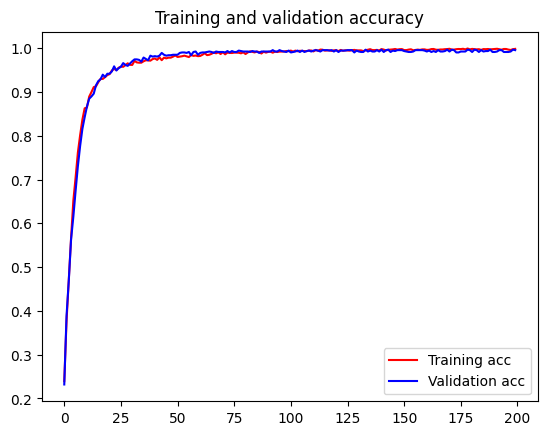

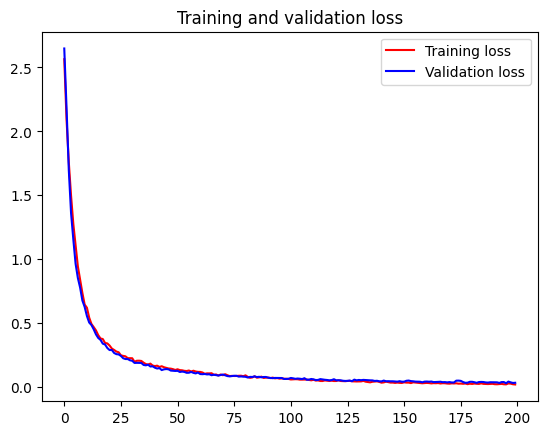

In [20]:
#plot graph to visualize the model performance
import matplotlib.pyplot as plt

acc = lstm_result.history['accuracy']
val_acc = lstm_result.history['val_accuracy']
loss = lstm_result.history['loss']
val_loss = lstm_result.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
#evaluate on test set
test_loss, test_accuracy = model.evaluate(test_dataset)

5/5 [==============================] - 1s 87ms/step - loss: 0.0799 - accuracy: 0.9800


In [22]:
from sklearn.metrics import confusion_matrix
# Access the ground truth labels
true_labels = test_labels
true_labels = np.argmax(test_labels, axis=1)
#confusion matrix
# Make predictions on the test data
predictions = model.predict(test_dataset)
predictions
# # Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes
# true_classes = np.array(true_labels)

# from sklearn.metrics import confusion_matrix
confusion_lstm = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(confusion_lstm)

5/5 [==============================] - 9s 97ms/step
Confusion Matrix:
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  8  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 10]]


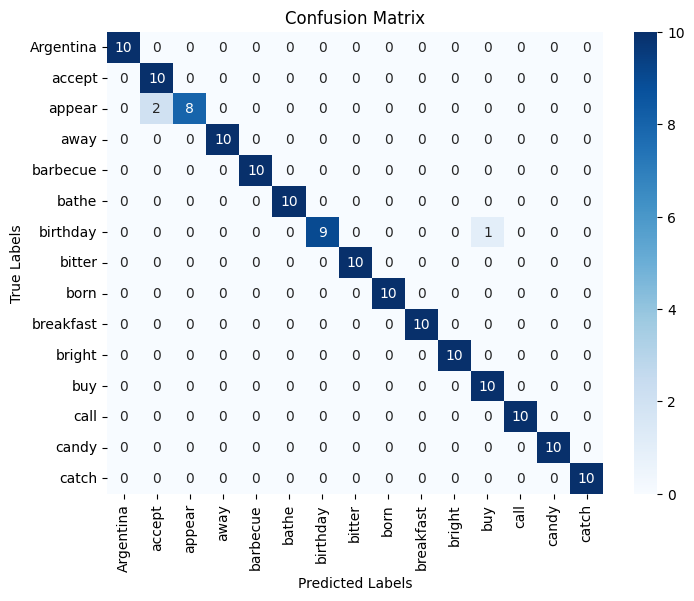

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_lstm, annot=True, fmt='d', cmap='Blues',xticklabels=glossLst, yticklabels=glossLst)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes, target_names=glossLst))

              precision    recall  f1-score   support

   Argentina       1.00      1.00      1.00        10
      accept       0.83      1.00      0.91        10
      appear       1.00      0.80      0.89        10
        away       1.00      1.00      1.00        10
    barbecue       1.00      1.00      1.00        10
       bathe       1.00      1.00      1.00        10
    birthday       1.00      0.90      0.95        10
      bitter       1.00      1.00      1.00        10
        born       1.00      1.00      1.00        10
   breakfast       1.00      1.00      1.00        10
      bright       1.00      1.00      1.00        10
         buy       0.91      1.00      0.95        10
        call       1.00      1.00      1.00        10
       candy       1.00      1.00      1.00        10
       catch       1.00      1.00      1.00        10

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98   

### Conv-GRU model

In [15]:
gru= Sequential()
gru.add(Input(shape=(190, 267)))
gru.add(Conv1D(32, 3, padding='same', activation='relu'))
gru.add(MaxPooling1D(3))
gru.add(Dropout(0.3))
gru.add(GRU(64, return_sequences=True))
gru.add(Dropout(0.5))
gru.add(BatchNormalization())
gru.add(GRU(128, return_sequences=True))
gru.add(Dropout(0.5))
gru.add(BatchNormalization())
gru.add(SeqSelfAttention(attention_activation='sigmoid',
                        kernel_regularizer=keras.regularizers.l2(0.001)))
gru.add(Flatten())
gru.add(Dense(15, activation='softmax'))

C:\Users\TSL\anaconda3\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [16]:
gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 190, 32)           25664     
                                                                 
 max_pooling1d (MaxPooling1  (None, 63, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 32)            0         
                                                                 
 gru (GRU)                   (None, 63, 64)            18816     
                                                                 
 dropout_1 (Dropout)         (None, 63, 64)            0         
                                                                 
 batch_normalization (Batch  (None, 63, 64)            256       
 Normalization)                                         

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True

callback=MyThresholdCallback(threshold=1.0) 

def lrSchedule(epoch):
    lr  = 0.0001
    if epoch < 10:
        lr = 0.001
        
    print('Learning rate: ', lr)
    return lr
LRScheduler= LearningRateScheduler(lrSchedule)

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
gru.compile(optimizer=opt, loss= tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])

In [20]:
gru_result=gru.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=[callback])

Epoch 1/200
136/136 [==============================] - 94s 362ms/step - loss: 2.6123 - accuracy: 0.1861 - val_loss: 2.5961 - val_accuracy: 0.1651
Epoch 2/200
136/136 [==============================] - 41s 300ms/step - loss: 2.2146 - accuracy: 0.3472 - val_loss: 2.1385 - val_accuracy: 0.4233
Epoch 3/200
136/136 [==============================] - 42s 305ms/step - loss: 1.8640 - accuracy: 0.4605 - val_loss: 1.6928 - val_accuracy: 0.5270
Epoch 4/200
136/136 [==============================] - 42s 306ms/step - loss: 1.5396 - accuracy: 0.5697 - val_loss: 1.3996 - val_accuracy: 0.5799
Epoch 5/200
136/136 [==============================] - 41s 304ms/step - loss: 1.2740 - accuracy: 0.6650 - val_loss: 1.1607 - val_accuracy: 0.6487
Epoch 6/200
136/136 [==============================] - 42s 311ms/step - loss: 1.0842 - accuracy: 0.7247 - val_loss: 0.9637 - val_accuracy: 0.7280
Epoch 7/200
136/136 [==============================] - 42s 308ms/step - loss: 0.9375 - accuracy: 0.7754 - val_loss: 0.8488 -

Epoch 57/200
136/136 [==============================] - 41s 300ms/step - loss: 0.1472 - accuracy: 0.9730 - val_loss: 0.1173 - val_accuracy: 0.9810
Epoch 58/200
136/136 [==============================] - 32s 234ms/step - loss: 0.1455 - accuracy: 0.9719 - val_loss: 0.1117 - val_accuracy: 0.9799
Epoch 59/200
136/136 [==============================] - 32s 233ms/step - loss: 0.1472 - accuracy: 0.9746 - val_loss: 0.1142 - val_accuracy: 0.9810
Epoch 60/200
136/136 [==============================] - 35s 253ms/step - loss: 0.1444 - accuracy: 0.9772 - val_loss: 0.1086 - val_accuracy: 0.9820
Epoch 61/200
136/136 [==============================] - 36s 254ms/step - loss: 0.1321 - accuracy: 0.9811 - val_loss: 0.1067 - val_accuracy: 0.9862
Epoch 62/200
136/136 [==============================] - 34s 245ms/step - loss: 0.1396 - accuracy: 0.9751 - val_loss: 0.1024 - val_accuracy: 0.9862
Epoch 63/200
136/136 [==============================] - 33s 240ms/step - loss: 0.1389 - accuracy: 0.9763 - val_loss: 0

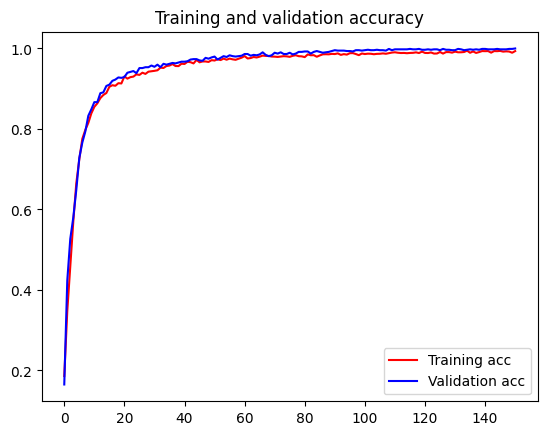

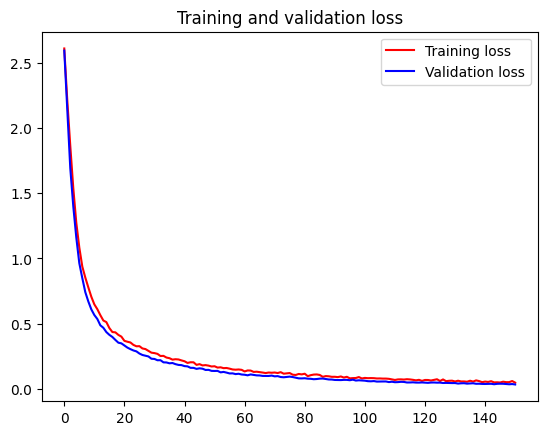

In [21]:
#plot graph to visualize the model performance
import matplotlib.pyplot as plt

acc = gru_result.history['accuracy']
val_acc = gru_result.history['val_accuracy']
loss = gru_result.history['loss']
val_loss = gru_result.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
#evaluate on test set
test_loss, test_accuracy = gru.evaluate(test_dataset)

5/5 [==============================] - 0s 75ms/step - loss: 0.2267 - accuracy: 0.9733


In [26]:
from sklearn.metrics import confusion_matrix
# Access the ground truth labels
true_labels = test_labels
true_labels = np.argmax(test_labels, axis=1)
#confusion matrix
# Make predictions on the test data
predictions = gru.predict(test_dataset)
predictions
# # Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes
# true_classes = np.array(true_labels)

# from sklearn.metrics import confusion_matrix
confusion_gru = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(confusion_lstm)

5/5 [==============================] - 0s 75ms/step
Confusion Matrix:
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  8  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 10]]


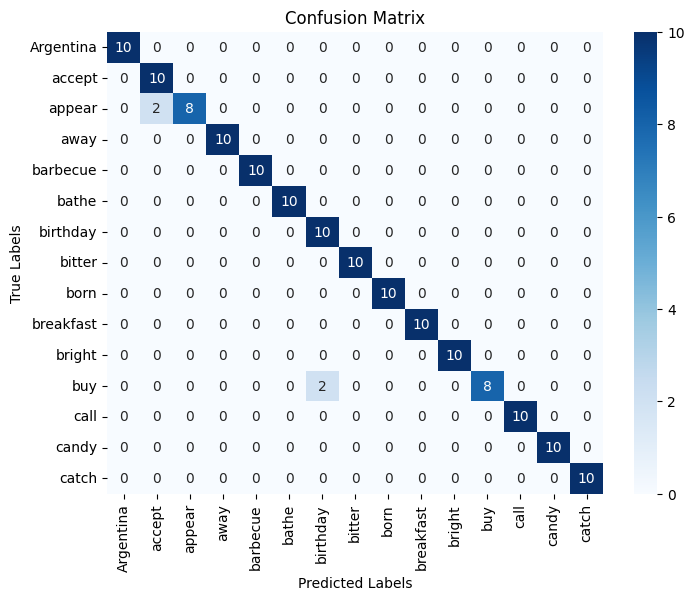

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_gru, annot=True, fmt='d', cmap='Blues',xticklabels=glossLst, yticklabels=glossLst)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes, target_names=glossLst))

              precision    recall  f1-score   support

   Argentina       1.00      1.00      1.00        10
      accept       0.83      1.00      0.91        10
      appear       1.00      0.80      0.89        10
        away       1.00      1.00      1.00        10
    barbecue       1.00      1.00      1.00        10
       bathe       1.00      1.00      1.00        10
    birthday       0.83      1.00      0.91        10
      bitter       1.00      1.00      1.00        10
        born       1.00      1.00      1.00        10
   breakfast       1.00      1.00      1.00        10
      bright       1.00      1.00      1.00        10
         buy       1.00      0.80      0.89        10
        call       1.00      1.00      1.00        10
       candy       1.00      1.00      1.00        10
       catch       1.00      1.00      1.00        10

    accuracy                           0.97       150
   macro avg       0.98      0.97      0.97       150
weighted avg       0.98   